In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import duckdb
import xarray as xr
import numpy as np
from pyquadkey2 import quadkey

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# configurations on jupysql to directly output data to Pandas and to simplify the output
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [11]:
con = duckdb.connect("../data/qudkeyDB.duckdb", read_only=True) # this should create a DB File
# con = duckdb.connect("../data/qudkeyDB.duckdb") # this should create a DB File
con.install_extension("spatial")
con.load_extension("spatial")


In [4]:
# If the table does not already exists, it will be created
# feel free to rename columns
create_table_query = """
CREATE TABLE if not exists data_slice_male_long_lat (
    quadkey VARCHAR,
    raster_1 FLOAT,
    raster_2 FLOAT,
    raster_3 FLOAT,
    raster_4 FLOAT,
    raster_5 FLOAT,
    raster_6 FLOAT,
    raster_7 FLOAT,
    raster_8 FLOAT,
    raster_9 FLOAT,
    raster_10 FLOAT,
    raster_11 FLOAT,
    raster_12 FLOAT,
    raster_13 FLOAT,
    raster_14 FLOAT,
    raster_15 FLOAT,
    raster_16 FLOAT,
    raster_17 FLOAT,
    raster_18 FLOAT,
    raster_19 FLOAT,
    raster_20 FLOAT,
    raster_21 FLOAT,
    raster_22 FLOAT,
    raster_23 FLOAT,
    raster_24 FLOAT,
    raster_25 FLOAT,
    raster_26 FLOAT,
    raster_27 FLOAT,
    raster_28 FLOAT,
    raster_29 FLOAT,
    raster_30 FLOAT
);
"""

# Execute the query to create the table
con.execute(create_table_query)

In [5]:
def insertIntoDB(df): # Insert dataframe into data_slice_male_long_lat
    con.sql(f"""
        INSERT INTO data_slice_male_long_lat
        SELECT * FROM df;
    """)


In [16]:
# deletes all data!!!!!!

#con.sql("""
#        truncate table data_slice_male_long_lat;
#    """)

In [6]:
# loads the .nc file into an xarray 

def load_dataset(file_path, lat_slice, lon_slice):
    dataset = xr.open_dataset(file_path)
    # TODO: Fix out of memory problem by using dask https://tutorial.xarray.dev/intermediate/xarray_and_dask.html
    data_slice = dataset.sel(latitude=lat_slice, longitude=lon_slice)
    data_slice = data_slice[
        "Basic Demographic Characteristics, v4.10 (2010): Male, Density, 2.5 arc-minutes"
    ]
    return data_slice.compute()

In [7]:
import pandas as pd
import numpy as np

# extraction of the data points from the xarray with their respective quadkeys

def extract_data_points_vectorized_quadkey(ds):
    data_points = []
    longs = ds.longitude.values
    lats = ds.latitude.values

    zoom_level = 14  # Adjust as needed for desired precision

    for x in range(len(lats)):  # Iterate over latitude indices
        for y in range(len(longs)):  # Iterate over longitude indices
            # Convert latitude and longitude to quadkey
            coord = (lats[x], longs[y])
            tile = quadkey.from_geo(coord, zoom_level)
            quadkey_str = tile.key
            
            # Extract raster values
            raster_values = ds.values[:, x, y]
            
            # Append a row with quadkey and raster values
            data_points.append([quadkey_str] + list(raster_values))

    # Create a DataFrame from the data points
    columns = ['quadkey'] + [f'raster_{i + 1}' for i in range(ds.shape[0])]
    df = pd.DataFrame(data_points, columns=columns)

    return df


In [8]:
# function for loading chunks of 10°*10° into the DB
def load_male_datasetIntoDB():
    file_path_male = "../data/gpw_v4_basic_demographic_characteristics_rev11_mt_2010_dens_2pt5_min.nc"

    # Initialize an empty DataFrame to store results
    # combined_df = pd.DataFrame()

    # Process the dataset in 10-degree latitude chunks
    # for lat_start in range(85, -90, -10):  # Iterate from 90 to -90 in steps of -10
    for lat_start in range(85, -85, -10):  # Iterate from 90 to -90 in steps of -10
        lat_end = lat_start - 10
        lat_slice = slice(lat_start, lat_end)

        # for lon_start in range(-180, 180, 10):  # Iterate from 90 to -90 in steps of -10
        for lon_start in range(-180, 180, 10):  # Iterate from 90 to -90 in steps of -10
            lon_end = lon_start + 10
            lon_slice = slice(lon_start, lon_end)
            print("lat: " + str(lat_start) + " long: " + str(lon_start))
            print("lat: " + str(lat_end) + " long: " + str(lon_end))

            # Load and process the chunk
            data_slice_male = load_dataset(file_path_male, lat_slice, lon_slice)
            data_slice_male_quadkey = extract_data_points_vectorized_quadkey(data_slice_male)

            insertIntoDB(data_slice_male_quadkey)

In [9]:
# n = zoomlevel must be parentlevel of the highest zoomlevel currently in the DB
def insertParentsForLevel(n, tableName):
    for group in range(0, 4): # run in chunks of 4, otherwise i ran out of memory; each group is defined by the first character of the quadkey (0-3)
        query = f"""
        INSERT INTO {tableName}
        SELECT
        SUBSTRING(quadkey, 1, {n} - 1) AS parent_quadkey,
        AVG(raster_1) * (COUNT(*) / 4) AS raster_1,
        AVG(raster_2) * (COUNT(*) / 4) AS raster_2,
        AVG(raster_3) * (COUNT(*) / 4) AS raster_3,
        AVG(raster_4) * (COUNT(*) / 4) AS raster_4,
        AVG(raster_5) * (COUNT(*) / 4) AS raster_5,
        AVG(raster_6) * (COUNT(*) / 4) AS raster_6,
        AVG(raster_7) * (COUNT(*) / 4) AS raster_7,
        AVG(raster_8) * (COUNT(*) / 4) AS raster_8,
        AVG(raster_9) * (COUNT(*) / 4) AS raster_9,
        AVG(raster_10) * (COUNT(*) / 4) AS raster_10,
        AVG(raster_11) * (COUNT(*) / 4) AS raster_11,
        AVG(raster_12) * (COUNT(*) / 4) AS raster_12,
        AVG(raster_13) * (COUNT(*) / 4) AS raster_13,
        AVG(raster_14) * (COUNT(*) / 4) AS raster_14,
        AVG(raster_15) * (COUNT(*) / 4) AS raster_15,
        AVG(raster_16) * (COUNT(*) / 4) AS raster_16,
        AVG(raster_17) * (COUNT(*) / 4) AS raster_17,
        AVG(raster_18) * (COUNT(*) / 4) AS raster_18,
        AVG(raster_19) * (COUNT(*) / 4) AS raster_19,
        AVG(raster_20) * (COUNT(*) / 4) AS raster_20,
        AVG(raster_21) * (COUNT(*) / 4) AS raster_21,
        AVG(raster_22) * (COUNT(*) / 4) AS raster_22,
        AVG(raster_23) * (COUNT(*) / 4) AS raster_23,
        AVG(raster_24) * (COUNT(*) / 4) AS raster_24,
        AVG(raster_25) * (COUNT(*) / 4) AS raster_25,
        AVG(raster_26) * (COUNT(*) / 4) AS raster_26,
        AVG(raster_27) * (COUNT(*) / 4) AS raster_27,
        AVG(raster_28) * (COUNT(*) / 4) AS raster_28,
        AVG(raster_29) * (COUNT(*) / 4) AS raster_29,
        AVG(raster_30) * (COUNT(*) / 4) AS raster_30
        FROM {tableName}
        Where LENGTH(quadkey) = {n}
        and SUBSTRING(quadkey,1,1) = '{group}'
        GROUP BY parent_quadkey
        """
        # Execute the query
        con.execute(query).fetchall()

In [10]:
# for each level all parents are insertet into the db; start with 14 when the xarray has been freshly loaded
# dont run if the db is alreay filled
def loadAllAggregationDataIntoDB():
    n = 14
    for n in range(n, 0, -1):
        print("level: " + str(n))
        insertParentsForLevel(n, "data_slice_male_long_lat")


In [ ]:
# delete higher levels if you fucked up
# con.sql("""
#         delete  FROM data_slice_male_long_lat
#         where LENGTH(quadkey) < 13
#     """)

In [11]:
# Loads the complete male Dataset at level 14 into the DB
# only run if the DB has no data inside

load_male_datasetIntoDB() # loads level 14 from source; took 10min for me
loadAllAggregationDataIntoDB() # loads aggregation for all levels; took 5min for me



lat: 85 long: -180
lat: 75 long: -170
lat: 85 long: -170
lat: 75 long: -160
lat: 85 long: -160
lat: 75 long: -150
lat: 85 long: -150
lat: 75 long: -140
lat: 85 long: -140
lat: 75 long: -130
lat: 85 long: -130
lat: 75 long: -120
lat: 85 long: -120
lat: 75 long: -110
lat: 85 long: -110
lat: 75 long: -100
lat: 85 long: -100
lat: 75 long: -90
lat: 85 long: -90
lat: 75 long: -80
lat: 85 long: -80
lat: 75 long: -70
lat: 85 long: -70
lat: 75 long: -60
lat: 85 long: -60
lat: 75 long: -50
lat: 85 long: -50
lat: 75 long: -40
lat: 85 long: -40
lat: 75 long: -30
lat: 85 long: -30
lat: 75 long: -20
lat: 85 long: -20
lat: 75 long: -10
lat: 85 long: -10
lat: 75 long: 0
lat: 85 long: 0
lat: 75 long: 10
lat: 85 long: 10
lat: 75 long: 20
lat: 85 long: 20
lat: 75 long: 30
lat: 85 long: 30
lat: 75 long: 40
lat: 85 long: 40
lat: 75 long: 50
lat: 85 long: 50
lat: 75 long: 60
lat: 85 long: 60
lat: 75 long: 70
lat: 85 long: 70
lat: 75 long: 80
lat: 85 long: 80
lat: 75 long: 90
lat: 85 long: 90
lat: 75 long: 1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

level: 13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

level: 12


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

level: 11


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

level: 10
level: 9
level: 8
level: 7
level: 6
level: 5
level: 4
level: 3
level: 2
level: 1


In [9]:
# validate data
con.sql("""
        SELECT * FROM data_slice_male_long_lat
    """)

con.sql("""
pragma show_tables    """)

┌──────────────────────────┐
│           name           │
│         varchar          │
├──────────────────────────┤
│ data_slice_male_long_lat │
│ subset_quadkey_data      │
└──────────────────────────┘

In [9]:
# close connection
# otherwise the fastapi might not work
con.close()

In [3]:
from pyquadkey2 import quadkey

x = 18
y = 13
z = 5
qkey = quadkey.from_tile((x, y), z)
qkey

12212

In [19]:
con.sql(
    f"""SELECT
        '12212100' AS parent_quadkey,
        avg(raster_1)
        FROM data_slice_male_long_lat
        group by parent_quadkey
    """)
con.sql(
    f"""SELECT
        '12212100' AS parent_quadkey,
        raster_1
        FROM data_slice_male_long_lat
        where quadkey = '122121001'   
        """)
 # 12212100       │ 1.749270248994536e+17 │

┌────────────────┬──────────┐
│ parent_quadkey │ raster_1 │
│    varchar     │  float   │
├────────────────┼──────────┤
│ 12212100       │     NULL │
└────────────────┴──────────┘

 122121002 │ 1208.6957 │
│ 122121000 │      NULL │
│ 122121003 │  9574.493 │
│ 122121001 │      NULL

In [7]:
con.sql("""
        SELECT quadkey FROM data_slice_male_long_lat
        group by quadkey
        having count(*) > 1
    """)

con.sql("""
        delete FROM data_slice_male_long_lat
        where quadkey = ''
    """)

In [8]:
con.sql("""
        CREATE UNIQUE INDEX quadkeyIndex ON data_slice_male_long_lat (quadkey);
    """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [1]:
def getData(quadkeys, con):
    if not quadkeys:
        return []
    values_clause = ", ".join(f"('{quadkey}')" for quadkey in quadkeys)
    # Query with list binding
    query = f"""
    WITH quadkey_temp(quadkey) AS (
        VALUES {values_clause}
    )
    SELECT t.*
    FROM data_slice_male_long_lat t
    JOIN quadkey_temp q
    ON t.quadkey = q.quadkey
    """
    # Execute the query
    result = con.execute(query).df()
    result = result.fillna(0)
    return result.to_dict(orient="records")


def loadTileMale(z, y, x, con):
    qkey = quadkey.from_tile((x, y), z)  # get quadtree for this tile
    listofQKeys = qkey.children(
        z + 5
    )  # get all children 3 levels deeper -> 64 data points for this til
    return getData(listofQKeys, con)

In [1]:
loadTileMale(z, y, x, con)

NameError: name 'loadTileMale' is not defined

In [ ]:
n = 14
tableName = "data_slice_male_long_lat"
query = f"""
    SELECT
    SUBSTRING(quadkey, 1, {n} - 1) AS parent_quadkey,
    raster_1,
    raster_2,
    raster_3,
    raster_4,
    raster_5,
    raster_6,
    raster_7,
    raster_8,
    raster_9,
     raster_10,
     raster_11,
     raster_12,
     raster_13,
     raster_14,
     raster_15,
     raster_16,
     raster_17,
     raster_18,
     raster_19,
     raster_20,
     raster_21,
     raster_22,
     raster_23,
     raster_24,
     raster_25,
     raster_26,
     raster_27,
     raster_28,
     raster_29,
     raster_30
    FROM {tableName}
    Where LENGTH(quadkey) = {n}
    and quadkey = '00000000200202'
    """
    # Execute the query
con.execute(query).fetchall()



[('0000000020020',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  3.0,
  None,
  None,
  32767.0,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None)]

In [18]:
import matplotlib.pyplot as plt

tableName = "data_slice_male_long_lat"
query = f"""
   select count(raster_1)
    FROM {tableName}
where raster_1 = 0
    """
    # Execute the query
con.execute(query).fetchall()

# 14.257.000
#  3.850.970
#  7.296.306


[(3850970,)]

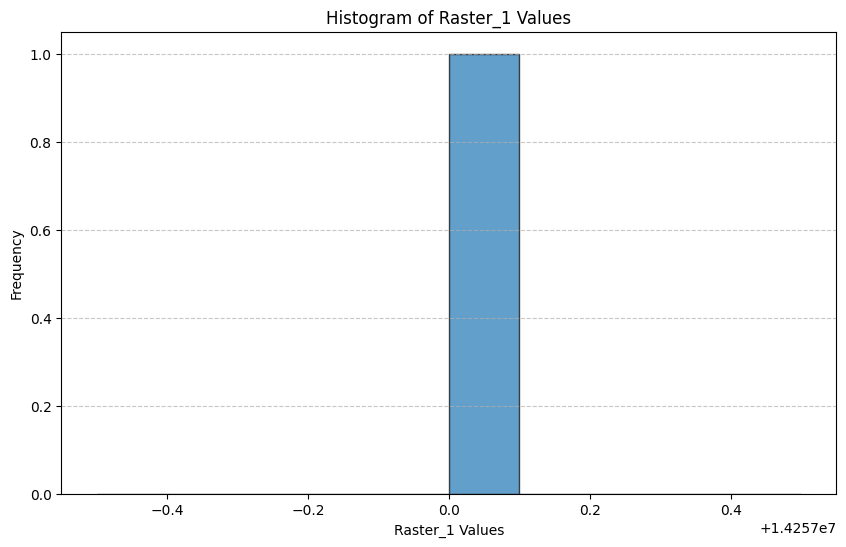

In [15]:
df = pd.DataFrame(result, columns=["raster_1"])


plt.figure(figsize=(10, 6))

plt.hist(df["raster_1"], bins=10, edgecolor="black", alpha=0.7)

plt.title("Histogram of Raster_1 Values")

plt.xlabel("Raster_1 Values")

plt.ylabel("Frequency")

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [13]:
from pyquadkey2 import quadkey

key = quadkey.from_str('0000000020020')
key.children()


[00000000200200, 00000000200201, 00000000200202, 00000000200203]